In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
#import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

#from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
#import mitequinox.sigp as sp




In [2]:
#Load data
path = '/Users/zcaspar/codes/mit4320/'
dsL = xr.open_dataset(path+'binned_Lcov_uu_dl2_new.nc') # Lagrangian SSU, 2° bins
dsL_flag = xr.open_dataset(path+'binned_Lcov_uu_dl2_flag.nc') # Lagrangian SSU, 2° bins, without flagged depth
dsL_flag10 = xr.open_dataset(path+'binned_Lcov_uu_dl2_flag10.nc') # Lagrangian SSU, 2° bins, without flagged depth
dsE = xr.open_dataset(path+'binned_Ecov_dl2.nc') # Eulerian SSU, 2° bins
dsE_low = xr.open_dataset(path+'binned_Ecov_low_dl2.nc') # Eulerian SSU, bf, 2° bins

dsL_dl1 = xr.open_dataset(path+'binned_Lcov_dl1.nc') # Lagrangian SSU, 1° bins
dsE_dl1 = xr.open_dataset(path+'binned_Ecov_dl1.nc') # Eulerian SSU, 1° bins

dsL_vv = xr.open_dataset(path+'binned_Lcov_vv.nc') # Lagrangian SSV, 2° bins
dsE_vv = xr.open_dataset(path+'binned_Ecov_vv_dl2.nc') # Eulerian SSV, 2° bins


#SSUV spectra
E_SSUV = xr.open_dataset(path+'/E_SSUV.nc') #Eulerian
L_SSUV = xr.open_dataset(path+'/L_SSUV.nc') #Lagrangian

In [3]:
# Subsampling Lagrangian data to  match Eulerian dataset
dsL = dsL.isel(lags=slice(0,None,3)).sel(lon_bins=dsE.lon_bins,lat_bins=dsE.lat_bins,method='nearest')#.sel(lon_bins=slice(-180,180),lat_bins=slice(-60,60))
dsL_flag = dsL_flag.isel(lags=slice(0,None,3)).sel(lon_bins=dsE.lon_bins,lat_bins=dsE.lat_bins,method='nearest')#.sel(lon_bins=slice(-180,180),lat_bins=slice(-60,60))
dsL_flag10 = dsL_flag10.isel(lags=slice(0,None,3)).sel(lon_bins=dsE.lon_bins,lat_bins=dsE.lat_bins,method='nearest')#.sel(lon_bins=slice(-180,180),lat_bins=slice(-60,60))

In [29]:
# Area of interest
bbox_cal = [-125,35] #california
bbox_med = [4,40] # mediterranean sea
bbox_nwa = [115,-15] # North-west Australia
bbox_nea = [160,-15] # North-west Australia
bbox_swa = [120,-40] # South-west Australia
#bbox_neh = [-160, 35] # North-east Hawaii
bbox_eq = [-125,0] #equator
bbox_atl = [-10,-20]

In [30]:
dsE = dsE.where(dsE.rr!=0) # change 0 to nan (corresponding to land)
dsE_vv = dsE_vv.where(dsE_vv.rr!=0) # change 0 to nan (corresponding to land)
dsE_low = dsE_low.where(dsE_low.rr!=0) # change 0 to nan (corresponding to land)
dsE_dl1 = dsE_dl1.where(dsE_dl1.rr!=0)

In [31]:
dsL = dsL.interp({'lon_bins':dsE.lon_bins})
dsL_flag = dsL_flag.interp({'lon_bins':dsE.lon_bins})
dsL_flag10 = dsL_flag10.interp({'lon_bins':dsE.lon_bins})

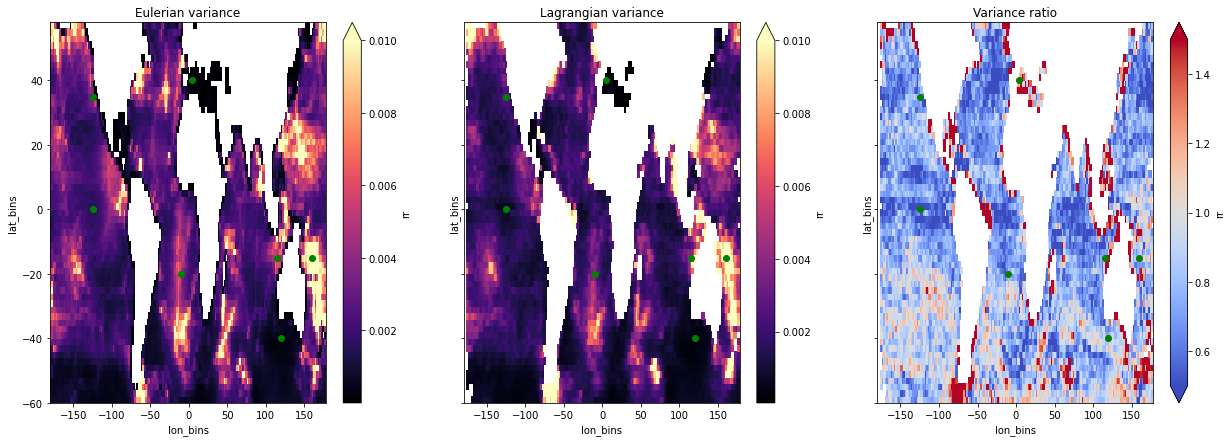

In [33]:
cmap ='magma'
fig,axs = plt.subplots(1,3,figsize=(21,7),sharey=True)
(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins')
axs[0].set_title('Eulerian variance')
(dsL.isel(lags=0).rr).plot(ax=axs[1],vmax=0.01,cmap=cmap,y='lat_bins')
axs[1].set_title('Lagrangian variance')
#(dsE_low['rr'].isel(lags=0)).plot(y='lat_bins',cmap=cmap,vmax=0.1,ax=axs[2])
(dsL['rr'].isel(lags=0)/dsE['rr'].isel(lags=0)).plot(cmap='coolwarm',vmax=1.5,y='lat_bins',vmin=0.5,ax=axs[2])
axs[2].set_title('Variance ratio')

for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq,bbox_atl]:
    axs[0].scatter(bbox[0],bbox[1],c='g')
    axs[1].scatter(bbox[0],bbox[1],c='g')
    axs[2].scatter(bbox[0],bbox[1],c='g')
#plt.show()

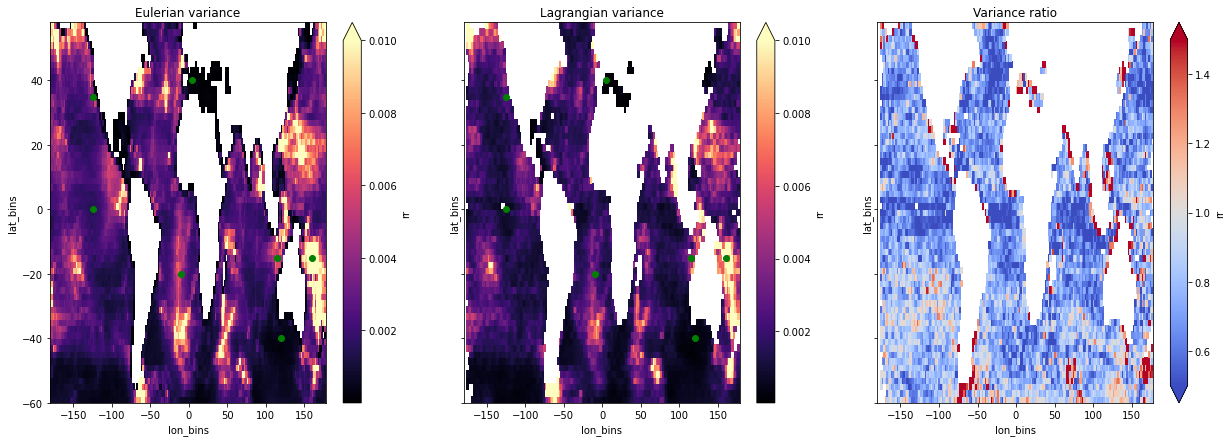

In [34]:
cmap ='magma'
fig,axs = plt.subplots(1,3,figsize=(21,7),sharey=True)
(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins')
axs[0].set_title('Eulerian variance')
(dsL_flag.isel(lags=0).rr).plot(ax=axs[1],vmax=0.01,cmap=cmap,y='lat_bins')
axs[1].set_title('Lagrangian variance')
#(dsE_low['rr'].isel(lags=0)).plot(y='lat_bins',cmap=cmap,vmax=0.1,ax=axs[2])
(dsL_flag['rr'].isel(lags=0)/dsE['rr'].isel(lags=0)).plot(cmap='coolwarm',vmax=1.5,y='lat_bins',vmin=0.5,ax=axs[2])
axs[2].set_title('Variance ratio')

for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq,bbox_atl]:
    axs[0].scatter(bbox[0],bbox[1],c='g')
    axs[1].scatter(bbox[0],bbox[1],c='g')
#    axs[2].scatter(bbox[0],bbox[1],c='g')
plt.show()    
fig.savefig('/Users/zcaspar/codes/mit4320/var_maps.png')

Text(0.5, 1.0, 'Variance ratio')

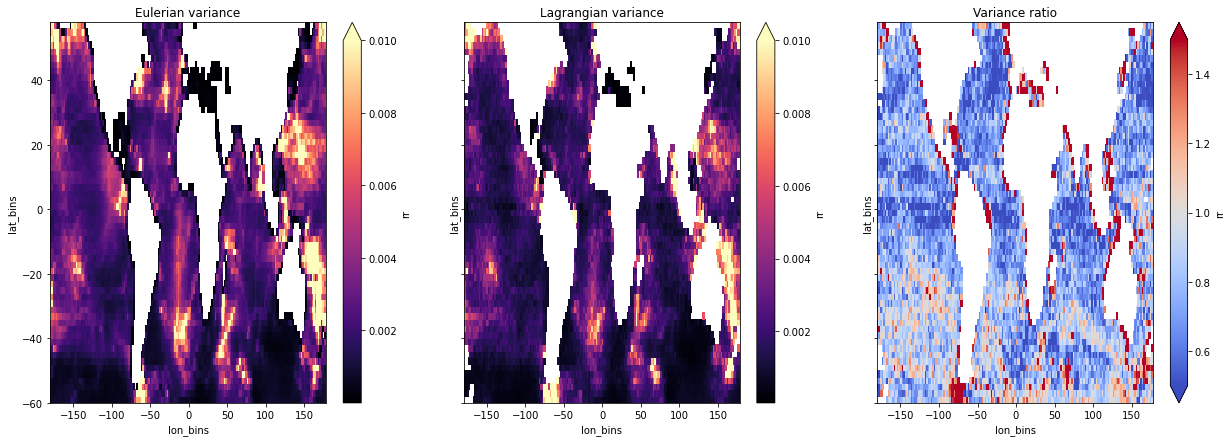

In [35]:
cmap ='magma'
fig,axs = plt.subplots(1,3,figsize=(21,7),sharey=True)
(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins')
axs[0].set_title('Eulerian variance')
(dsL_flag10.isel(lags=0).rr).plot(ax=axs[1],vmax=0.01,cmap=cmap,y='lat_bins')
axs[1].set_title('Lagrangian variance')
#(dsE_low['rr'].isel(lags=0)).plot(y='lat_bins',cmap=cmap,vmax=0.1,ax=axs[2])
(dsL_flag10['rr'].isel(lags=0)/dsE['rr'].isel(lags=0)).plot(cmap='coolwarm',vmax=1.5,y='lat_bins',vmin=0.5,ax=axs[2])
axs[2].set_title('Variance ratio')

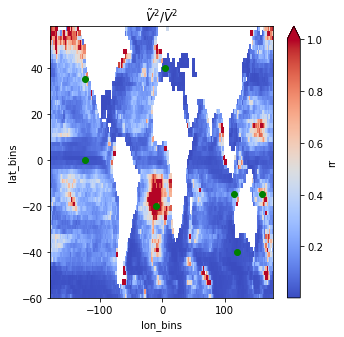

In [39]:
fig,ax = plt.subplots(figsize=(5,5))
(dsE['rr'].isel(lags=0)/dsE_low['rr'].isel(lags=0)).plot(cmap='coolwarm',y='lat_bins',vmax=1)
for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq,bbox_atl]:
    ax.scatter(bbox[0],bbox[1],c='g')
ax.set_title(r'$\tilde V^2/\bar V^2$')
fig.savefig('/Users/zcaspar/codes/mit4320/var_ratio.png')

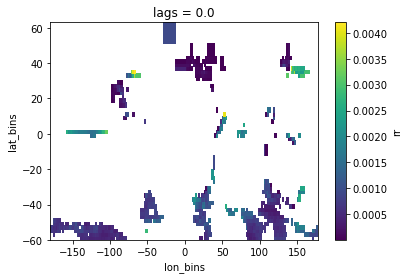

In [64]:
dsE.where(dsE_low['rr'].isel(lags=0)/dsE['rr'].isel(lags=0)>50,drop=True).rr.isel(lags=0).plot(y='lat_bins')

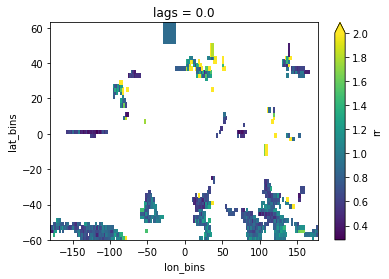

In [71]:
(dsL_flag10['rr'].isel(lags=0)/dsE['rr'].isel(lags=0)).where(dsE_low['rr'].isel(lags=0)/dsE['rr'].isel(lags=0)>50,drop=True).plot(vmax=2)

In [52]:
dsE.mean(['lat_bins','lon_bins'])/dsE.mean(['lat_bins','lon_bins']).isel(lags=0)

<xarray.Dataset>
Dimensions:  (lags: 321)
Coordinates:
  * lags     (lags) float64 0.0 0.125 0.25 0.375 0.5 ... 39.62 39.75 39.88 40.0
Data variables:
    rr       (lags) float64 1.0 0.9991 0.9965 0.9923 ... -0.2474 -0.256 -0.2644
    ri       (lags) float64 1.0 -3.163 -7.317 -11.45 ... -58.53 -57.45 -56.34
    count    (lags) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

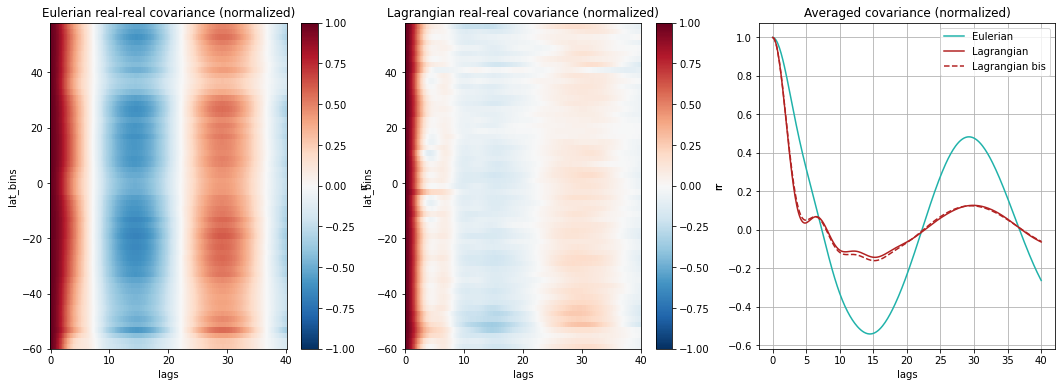

In [11]:
ce,cl = 'lightseagreen','firebrick'
fig,axs = plt.subplots(1,3,figsize=(18,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[0],vmax=1)
#(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
(dsL_flag.mean('lon_bins')/dsL_flag.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
(dsE.mean(['lat_bins','lon_bins'])/dsE.mean(['lat_bins','lon_bins']
                                           ).isel(lags=0)).rr.plot(c=ce,ax=axs[2],label='Eulerian')
(dsL_flag.mean(['lat_bins','lon_bins'])/dsL_flag.mean(['lat_bins','lon_bins']
                                                     ).isel(lags=0)).rr.plot(c=cl,ax=axs[2],label='Lagrangian')
(dsL_flag10.mean(['lat_bins','lon_bins'])/dsL_flag10.mean(['lat_bins','lon_bins']
                                                     ).isel(lags=0)).rr.plot(c=cl,ax=axs[2],linestyle='--',
                                                                             label='Lagrangian bis')
axs[0].set_title('Eulerian real-real covariance (normalized)')
axs[1].set_title('Lagrangian real-real covariance (normalized)')
axs[2].set_title('Averaged covariance (normalized)')
axs[2].grid();axs[2].legend()
#axs[2].set_title('Lagrangian real-real covariance (normalized) : coastal area removed')
fig.savefig('/Users/zcaspar/codes/mit4320/autocov.pdf')

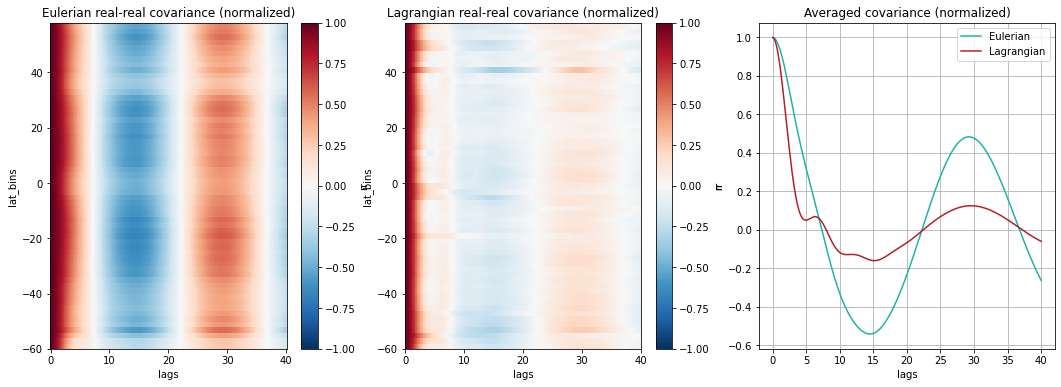

In [53]:
ce,cl = 'lightseagreen','firebrick'
fig,axs = plt.subplots(1,3,figsize=(18,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[0],vmax=1)
#(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
(dsL_flag10.mean('lon_bins')/dsL_flag10.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
(dsE.mean(['lat_bins','lon_bins'])/dsE.mean(['lat_bins','lon_bins']
                                           ).isel(lags=0)).rr.plot(c=ce,ax=axs[2],label='Eulerian')
(dsL_flag10.mean(['lat_bins','lon_bins'])/dsL_flag10.mean(['lat_bins','lon_bins']
                                                     ).isel(lags=0)).rr.plot(c=cl,ax=axs[2],label='Lagrangian')
axs[0].set_title('Eulerian real-real covariance (normalized)')
axs[1].set_title('Lagrangian real-real covariance (normalized)')
axs[2].set_title('Averaged covariance (normalized)')
axs[2].grid();axs[2].legend()
#axs[2].set_title('Lagrangian real-real covariance (normalized) : coastal area removed')
#fig.savefig('/Users/zcaspar/codes/mit4320/autocov.pdf'

Text(0.5, 1.0, 'Lagrangian real-imag covariance : coastal area removed')

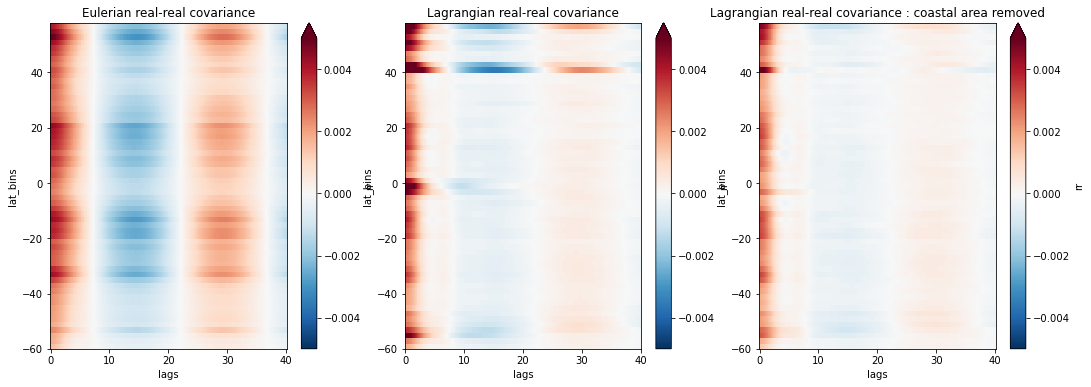

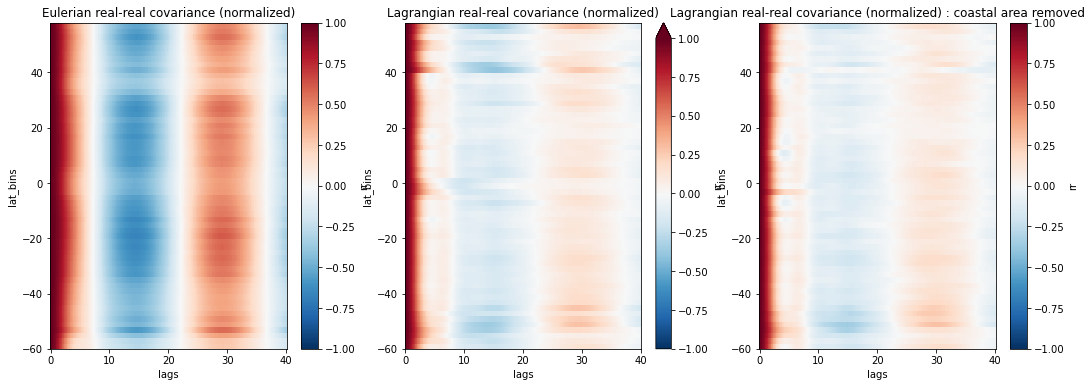

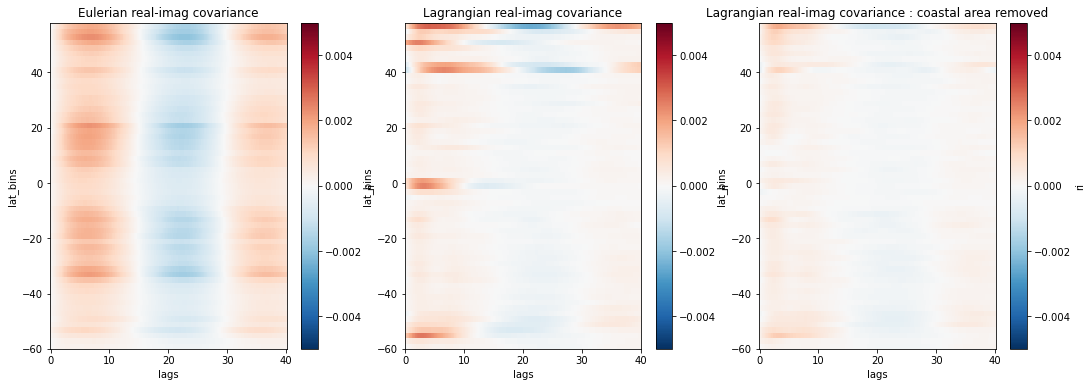

In [24]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
dsE.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[1],vmax=0.005)
dsL_flag.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[2],vmax=0.005)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')
axs[2].set_title('Lagrangian real-real covariance : coastal area removed')

fig,axs = plt.subplots(1,3,figsize=(18,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[0],vmax=1)
(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
(dsL_flag.mean('lon_bins')/dsL_flag.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[2],vmax=1)
axs[0].set_title('Eulerian real-real covariance (normalized)')
axs[1].set_title('Lagrangian real-real covariance (normalized)')
axs[2].set_title('Lagrangian real-real covariance (normalized) : coastal area removed')

fig,axs = plt.subplots(1,3,figsize=(18,6))
dsE.mean('lon_bins').ri.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL.mean('lon_bins').ri.plot(y='lat_bins',ax=axs[1],vmax=0.005)
dsL_flag.mean('lon_bins').ri.plot(y='lat_bins',ax=axs[2],vmax=0.005)
axs[0].set_title('Eulerian real-imag covariance')
axs[1].set_title('Lagrangian real-imag covariance')
axs[2].set_title('Lagrangian real-imag covariance : coastal area removed')

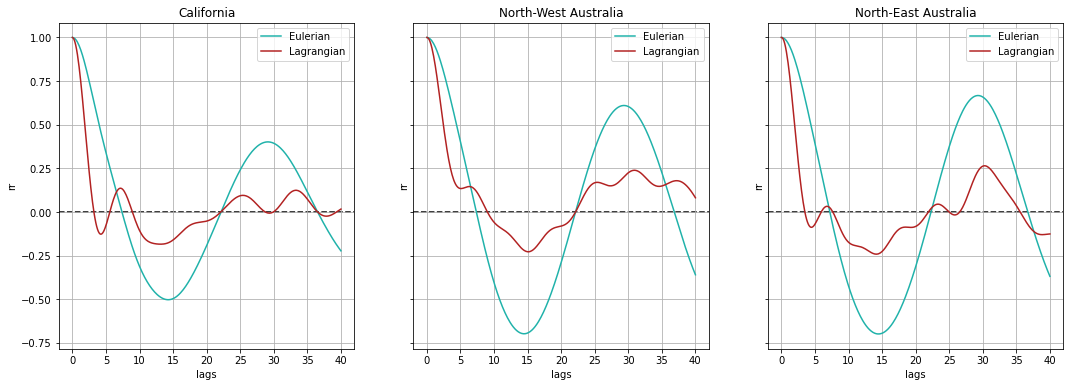

In [40]:
bbox = [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq,bbox_pac]
titles = ['California', 'North-West Australia','North-East Australia',
          'South-West Australia','Mediterranean sea','Equator (Pacific ocean)','Pacific ocean']
fig,ax = plt.subplots(1,len(bbox[:3]),figsize=(6*len(bbox[:3]),6),sharey=True)
for i,title in zip(range(len(bbox[:3])),titles[:3]):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    (dsL_flag/dsL_flag.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend()
    ax[i].set_title(title)
    ax[i].axhline(0,c='k',zorder=0,linestyle='--')
fig.savefig('/Users/zcaspar/codes/mit4320/autocov_01.pdf')

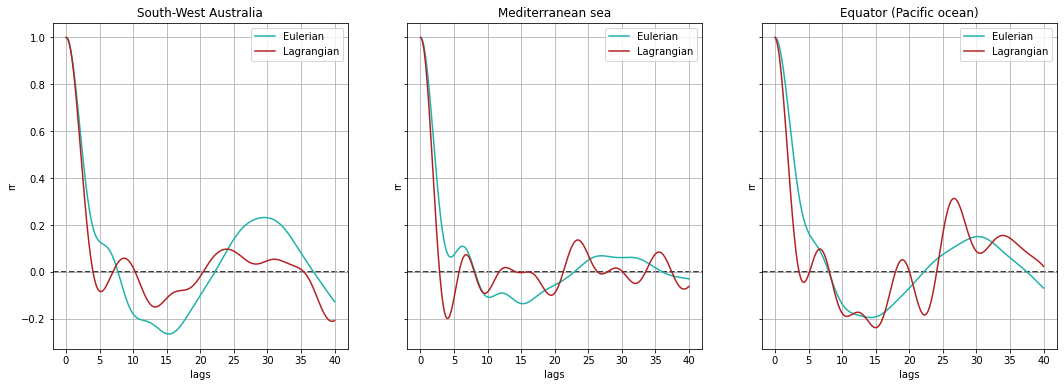

In [41]:
fig,ax = plt.subplots(1,len(bbox[3:-1]),figsize=(6*len(bbox[3:-1]),6),sharey=True)
for b,a,title in zip(bbox[3:-1],ax,titles[3:-1]):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest').rr.plot(ax=a,c='lightseagreen',label='Eulerian')
    (dsL_flag/dsL_flag.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest').rr.plot(ax=a,c='firebrick',label='Lagrangian')
    a.grid();a.legend()
    a.set_title(title)
    a.axhline(0,c='k',zorder=0,linestyle='--')
fig.savefig('/Users/zcaspar/codes/mit4320/autocov_001.pdf')

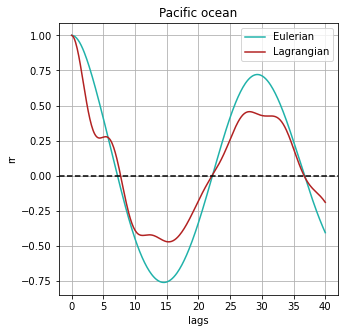

In [44]:
b = bbox_atl
fig,ax = plt.subplots(figsize=(5,5))
(dsE/dsE.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest'
                          ).rr.plot(ax=ax,c='lightseagreen',label='Eulerian')
(dsL_flag/dsL_flag.isel(lags=0)).sel(lat_bins=b[1],lon_bins=b[0],method='nearest'
                                        ).rr.plot(ax=ax,c='firebrick',label='Lagrangian')
ax.grid();ax.axhline(0,linestyle='--',c='k');
ax.legend();ax.set_title(titles[-1])
fig.savefig('/Users/zcaspar/codes/mit4320/autocov_1.pdf')

In [23]:
b

[-100, -20]